In [70]:
#Import Packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import datetime
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## **1. Penjelasan Eksperimen**



Misalnya suatu perusahaan *E-Commerce* telah membuat versi desain baru dari halaman web yang dimilikinya. Diharapkan desain baru tersebut dapat meningkatkan tingkat konversi *(conversion rate)* halaman web. Dengan itu, kita dapat membagi pengguna *website* menjadi 2 grup:
1. **control**: Pengunjung *website* lama
2. **treatment**: Pengunjung *website* baru

Diketahui tingkat konversi saat ini yaitu 12%, dan perusahaan membutuhkan peningkatan 1% atau desain baru halaman web sukses jika tingkat konversi meningkat menjadi 13%

Tingkat konversi dapat dilihat dengan membagi jumlah pembeli dan jumlah pengunjung toko selama periode waktu tertentu (dalam kasus ini, 1 minggu) Kita dapat menggunakan variabel biner untuk menggambarkan fenomena tersebut:
- **0**: user tidak membeli produk dalam waktu 7 hari dari paparan pertama
-**1**: user melakukan pembelian produk dalam waktu 7 hari dari paparan pertama

### **Ukuran sampel**

Perlu diketahui kita tidak akan menguji seluruh basis pengguna (populasi) dikarenakan semakin besar sampel yang digunakan, maka semakin memakan waktu, biaya (dan tidak praktis) penelitian menjadi.

Untuk mengestimasi ukuran sampel, kita akan gunakan **Power analysis** dengan:
- **power of the test $(1-\beta)$** : 0.9
- **alpha $(\alpha)$** : 0.05
- **effect size** : besar perbedaan tingkat konversi yang diharapkan (dalam kasus ini, 2%)

In [71]:
effect_size = sms.proportion_effectsize(0.12, 0.13) 
sample = sms.NormalIndPower().solve_power(effect_size, power=0.9, alpha=0.05, ratio=1)                                                  
sample = ceil(sample)                         
print("Kita membutuhkan setidaknya " + str(sample) + " pengamatan untuk setiap kelompok.")

Kita membutuhkan setidaknya 22977 pengamatan untuk setiap kelompok.


## **2. Pengumpulan Data**

Setelah menemukan jumlah sampel yang sesuai untuk penelitian, saatnya mengumpulkan data yang sesuai dari perusahaan. Namun, karena kita menggunakan dataset yang ditemukan online pada [kaggle](https://www.kaggle.com/code/yanadav/a-b-testing-new-version-of-a-site/data) maka kita dapat mengambil sampel secara acak dari dataframe ketika dataset sudah dicek dan dibersihkan terlebih dahulu.

In [72]:
df =pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [73]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Data dikumpulkan selama {data_duration} hari")
print(f"Persentase user grup control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Data dikumpulkan selama 21 hari
Persentase user grup control: 50%


## **3. Data Cleaning dan Preprocessing**

In [74]:
#Melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [75]:
#memastikan tidak ada user sama yang mengunjungi halaman web lama dan baru
counter = df['user_id'].value_counts()
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

Sebanyak 3894 user yang muncul lebih dari satu kali dalam dataset. Karena jumlahnya cukup rendah $(1.35\%)$ maka dapat langsung dikeluarkan dari dataframe. 

In [76]:
#Mengeluarkan user yang sama
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

In [77]:
#Pengecekan
df['user_id'].duplicated().sum()

0

### **Sampling**

Sekarang, kita dapat melakukan Simple Random Sampling dengan bantuan pandas dan sampel n = 22977

In [78]:
control_sample = df[df['group'] == 'control'].sample(n=sample, random_state=1)
treatment_sample = df[df['group'] == 'treatment'].sample(n=sample, random_state=1)

df1 = pd.concat([control_sample, treatment_sample], axis=0)
df1.reset_index(drop=True, inplace=True)

In [79]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45954 entries, 0 to 45953
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       45954 non-null  int64 
 1   timestamp     45954 non-null  object
 2   group         45954 non-null  object
 3   landing_page  45954 non-null  object
 4   converted     45954 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [80]:
df1['group'].value_counts()

control      22977
treatment    22977
Name: group, dtype: int64

## **4. Analisis Tingkat Konversi**

In [81]:
df1.groupby('group')['converted'].mean()*100

group
control      11.846629
treatment    11.594203
Name: converted, dtype: float64

Dilihat dari statistik di atas, sepertinya kedua desain tampil sangat mirip, dengan desain baru berkinerja lebih buruk, kira-kira. Tingkat konversi didapatkan 11.8% untuk grup control (desain *website* lama) vs. 11.6% untuk grup treatment (desain *website* baru)

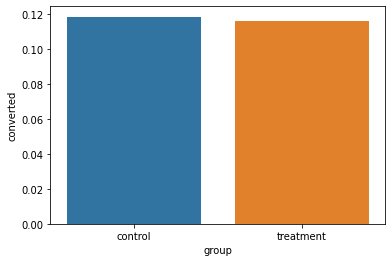

In [82]:
#Visualisasi tingkat konversi kedua kelompok
sns.barplot(x=df1['group'], y=df1['converted'], ci=False)

Tingkat konversi kedua grup dapat terlihat perbedaannya, namun terlihat sangat kecil. Nilai grup treatment lebih rendah mengindikasikan gagalnya usaha peningkatan tingkat konversi *website* dengan desain baru. Namun, kita tidak boleh mengambil kesimpulan langsung. Perlu diketahui apakah perbedaan antara grup control dengan grup treatment **signifikan secara statistika.**

## **5. Menguji Hipotesis**

### **Z-Test**

Dalam kasus ini, karena ukuran sampel sangat besar, berdasarkan Teori Limit Pusat *(Central Limit Theorem)* distribusi samplingnya akan mendekati distribusi normal, sehingga kita dapat menggunakan *Z-test* (uji z) 

Hipotesisnya:
<center> $H_0$: Perbedaan proporsi tidak signifikan
<center> $H_1$: Perbedaan proporsi signifikan

Tingkat kepercayaan:

$(\alpha)=0.05$

In [83]:
#Uji Statistik:

control = df1[df1['group'] == 'control']['converted']
treatment = df1[df1['group'] == 'treatment']['converted']

trials = [control.count(), treatment.count()]
successes = [control.sum(), treatment.sum()]

z_stat, pval = proportions_ztest(successes, trials, alternative='two-sided')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, trials, alpha=0.05)

print(f'z statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
if pval < 0.05:
    print('Hipotesis nol ditolak: Terdapat perbedaan signifikan antar proporsi')
else:
    print('Hipotesis nol gagal ditolak, tidak terdapat cukup bukti untuk mengatakan proporsi signifikan')
print('********************************************************')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.841
p-value: 0.400
Hipotesis nol gagal ditolak, tidak terdapat cukup bukti untuk mengatakan proporsi signifikan
********************************************************
95% Confidence interval for control group: [0.114, 0.123]
95% Confidence interval for treatment group: [0.112, 0.120]


Kesimpulan: 

Karena $p$-value = $0.4>0.05=\alpha$, maka $H_0$ gagal ditolak. Artinya, desain baru *website* tidak berbeda secara signifikan dari desain lama.

### **Chi-Squared Test**

*Chi-squared test* ($\chi^2$ test) juga dapat digunakan dalam penelitian, karena kita melakukan pengujian A/B pada tingkat konversi yang merupakan variabel kategorik. Ia mengikuti distribusi probabilitas diskrit yang memiliki probabilitas 1 dan probabilitas 0.

Dalam kasus ini, perhatikan kolom *converted* atau tingkat konversi. Pengguna akan melakukan pembelian (1) atau tidak melakukan pembelian (0)

Jika kita membuat tabel kontingensi 2x2 untuk frekuensi yang diamati dan membandingkannya dengan tabel kontingensi 2x2 untuk frekuensi yang diharapkan, kita dapat melakukan uji $\chi^2$ dengan Hipotesis:

<center> $H_0$: Tidak ada hubungan antara grup kontrol (control) dan perlakuan (treatment)
<center> $H_1$: Terdapat hubungan antara grup kontrol  (control) dan perlakuan (treatment)


Sebagai referensi, tabel kontingensi 2x2 akan memiliki dua kelompok: treatment/control atau converted/not converted. Terdapat 4 perhitungan yang akan ada di tabel:

1. Control, converted 
2. Treatment, converted 
3. Control, not converted
4. Treatment, not converted

In [84]:
#Perhitungan tabel kontingensi
control = df1[df1['group']=='control']
treatment = df1[df1['group']=='treatment']

control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

#Membuat tabel kontingensi
chi = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])
chi

array([[ 2722, 20255],
       [ 2664, 20313]])

In [85]:
print(stats.chi2_contingency(chi,correction=False)[1])

0.40027342076204153


Kesimpulan: 

Karena $p$-value = $0.4>0.05=\alpha$, maka $H_0$ gagal ditolak. Artinya, desain baru *website* tidak berbeda secara signifikan dari desain lama.

## **6. Rekomendasi**

Eksperimen A/B Testing ini dirancang untuk menentukan apakah desain *website*  baru perusahaan *e-commerce* akan meningkatkan tingkat konversi penggunanya dibandingkan dengan desain *website* lama.

Setelah pemeriksaan, persyaratan ukuran sampel minimum, dan beberapa metode statistik untuk menentukan *outcome* uji A/B, Dapat dilihat bahwa tujuan dasar perusahaan belum tercapai dengan desain *website* baru mereka. 

Dengan demikian, kami menyarankan untuk tidak melanjutkan perbaruan desain *website*, tetapi melakukan eksperimen lain.